<a href="https://colab.research.google.com/github/diegomrodrigues/transformers_experiments/blob/main/Residual%20Stream%20in%20Transformer%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

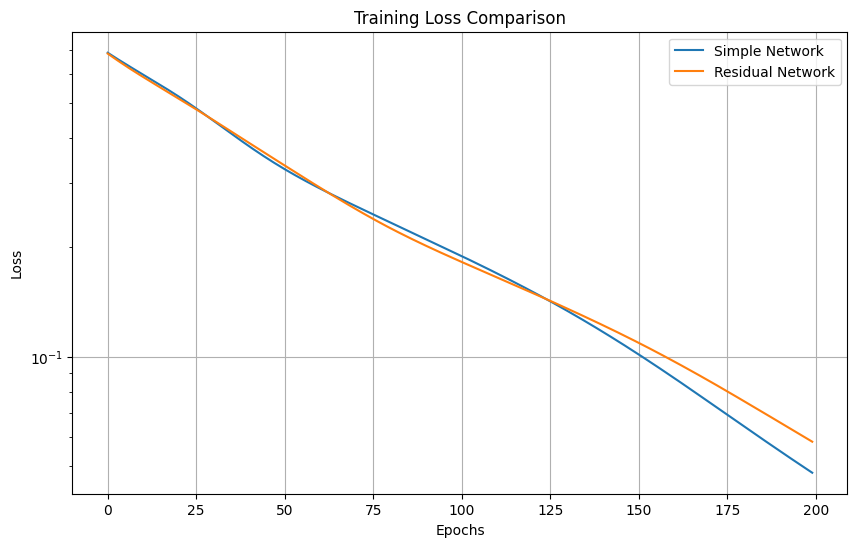

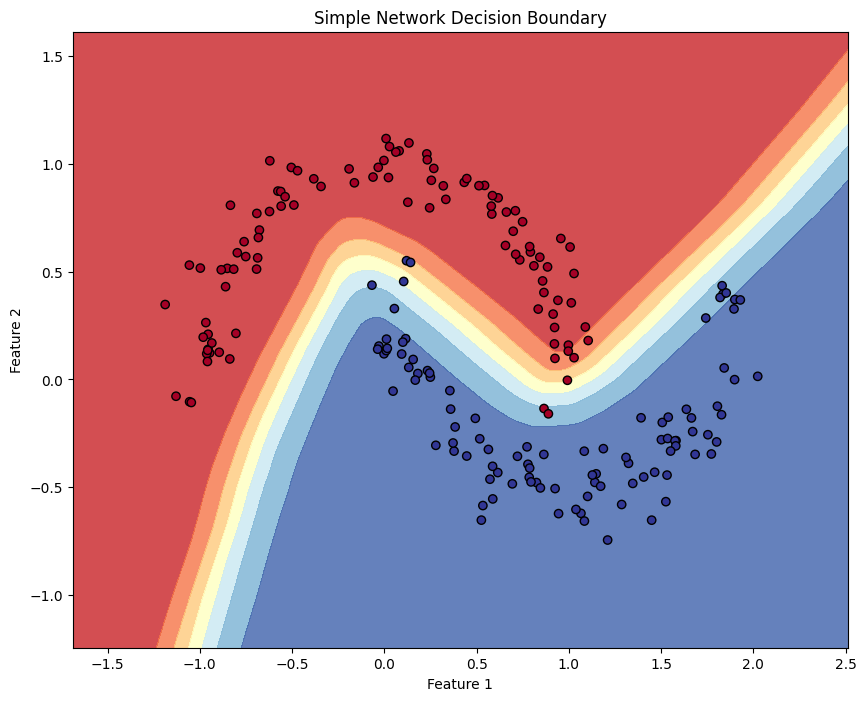

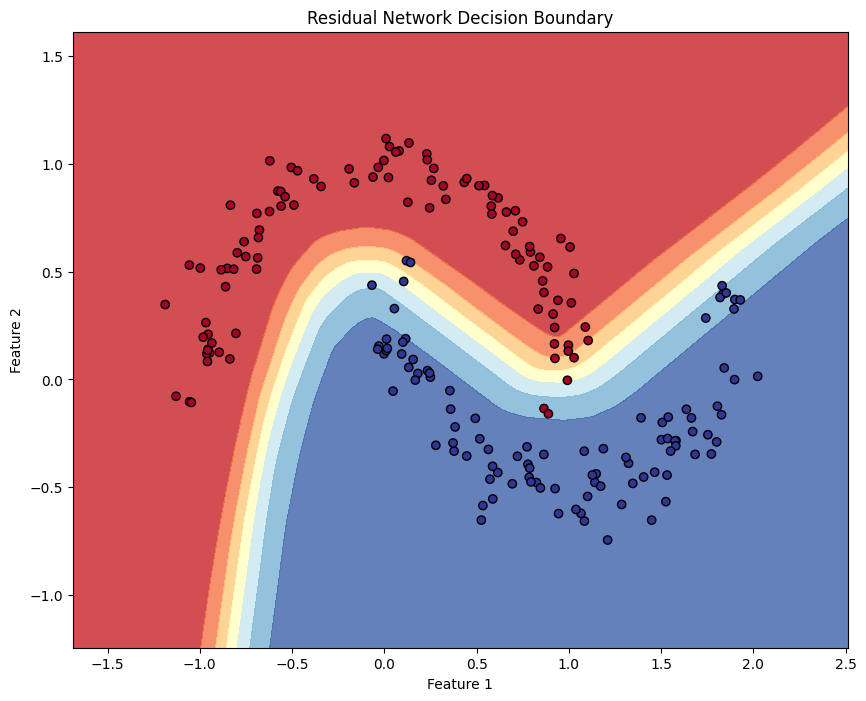

Simple Network Accuracy: 0.5001
Residual Network Accuracy: 0.5000


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import torch.nn as nn
import torch.optim as optim

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate a simple dataset
X, y = make_moons(n_samples=1000, noise=0.1)
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

# Split the data into train and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define a simple neural network without residual connections
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Define a neural network with residual connections
class ResidualNet(nn.Module):
    def __init__(self):
        super(ResidualNet, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        identity = self.fc1(x)
        x = torch.relu(identity)
        x = torch.relu(self.fc2(x) + identity)
        x = torch.sigmoid(self.fc3(x))
        return x

# Function to train the model and return loss history
def train_model(model, X_train, y_train, epochs=200):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return losses

# Train both models
simple_model = SimpleNet()
residual_model = ResidualNet()

simple_losses = train_model(simple_model, X_train, y_train)
residual_losses = train_model(residual_model, X_train, y_train)

# Visualize the training loss
plt.figure(figsize=(10, 6))
plt.plot(simple_losses, label='Simple Network')
plt.plot(residual_losses, label='Residual Network')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

# Function to create decision boundary plot
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).detach().numpy()
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Plot decision boundaries
plot_decision_boundary(simple_model, X_test, y_test, 'Simple Network Decision Boundary')
plot_decision_boundary(residual_model, X_test, y_test, 'Residual Network Decision Boundary')

# Evaluate models
simple_accuracy = (simple_model(X_test).round() == y_test).float().mean().item()
residual_accuracy = (residual_model(X_test).round() == y_test).float().mean().item()

print(f"Simple Network Accuracy: {simple_accuracy:.4f}")
print(f"Residual Network Accuracy: {residual_accuracy:.4f}")


Training models with depth 10
Training Simple Network:
Epoch [100/100], Loss: 0.3237

Training Residual Network:
Epoch [100/100], Loss: 0.0593

Depth 10 Results:
Simple Network Accuracy: 0.8920
Residual Network Accuracy: 0.9450

Training models with depth 20
Training Simple Network:
Epoch [100/100], Loss: 0.6931

Training Residual Network:
Epoch [100/100], Loss: 0.0417

Depth 20 Results:
Simple Network Accuracy: 0.4915
Residual Network Accuracy: 0.9430


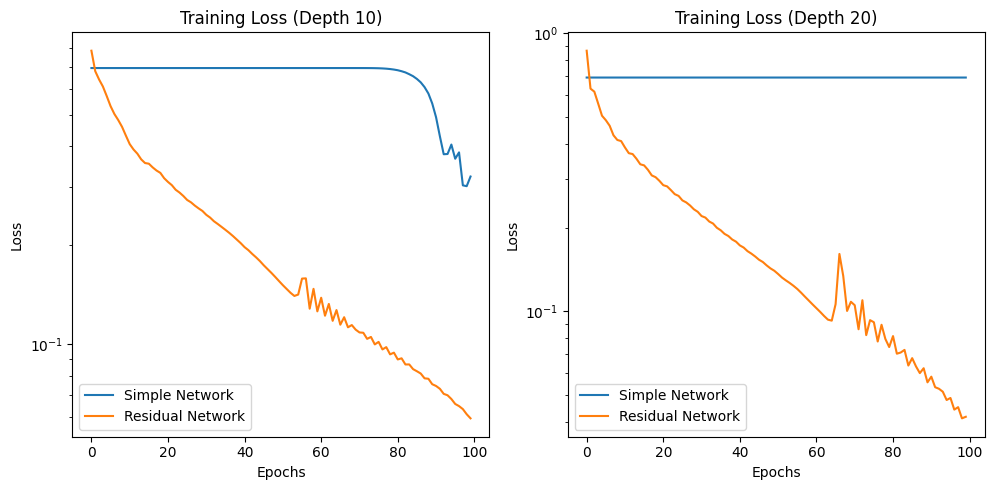

Epoch [100/100], Loss: 0.6931
Epoch [100/100], Loss: 0.2135


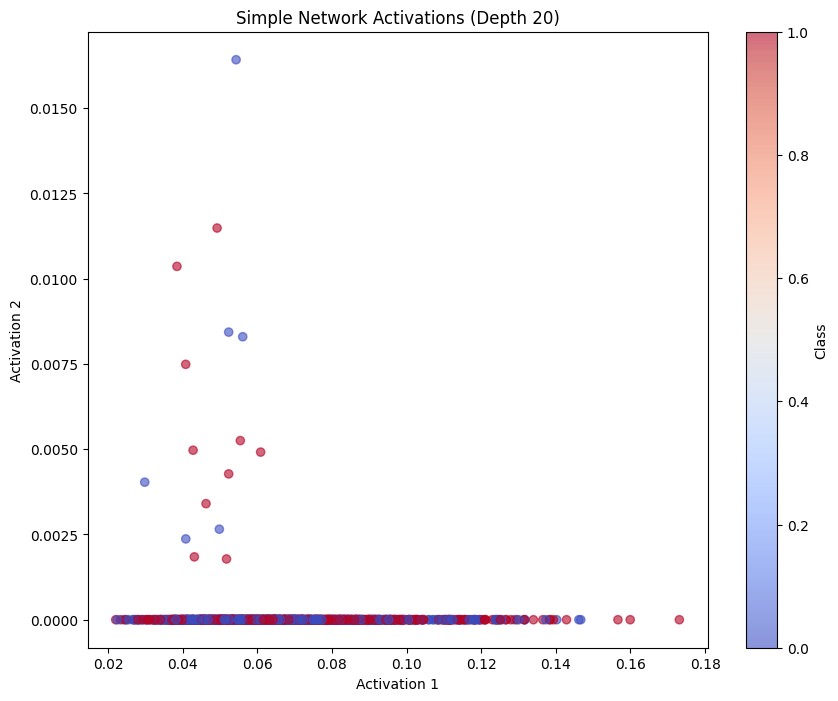

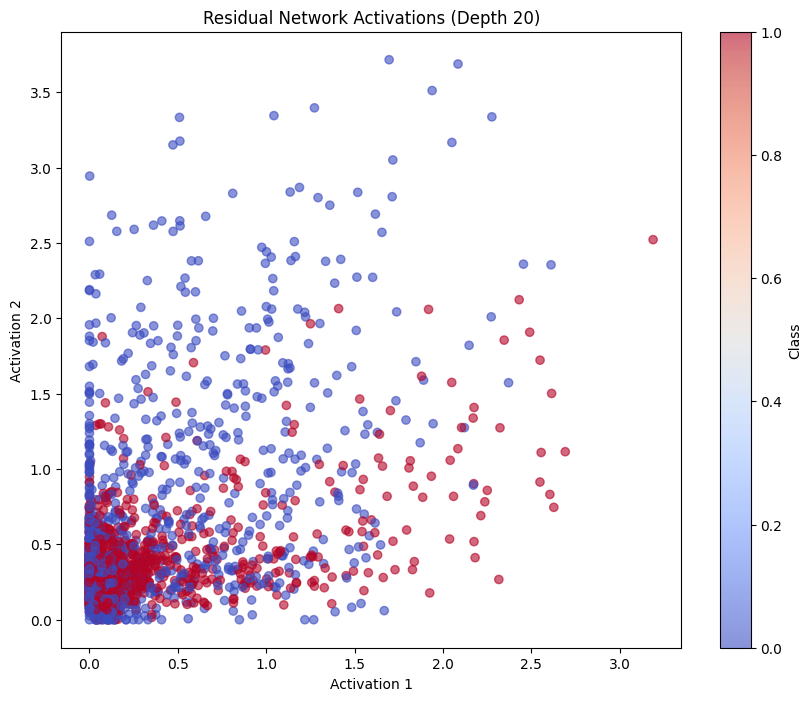

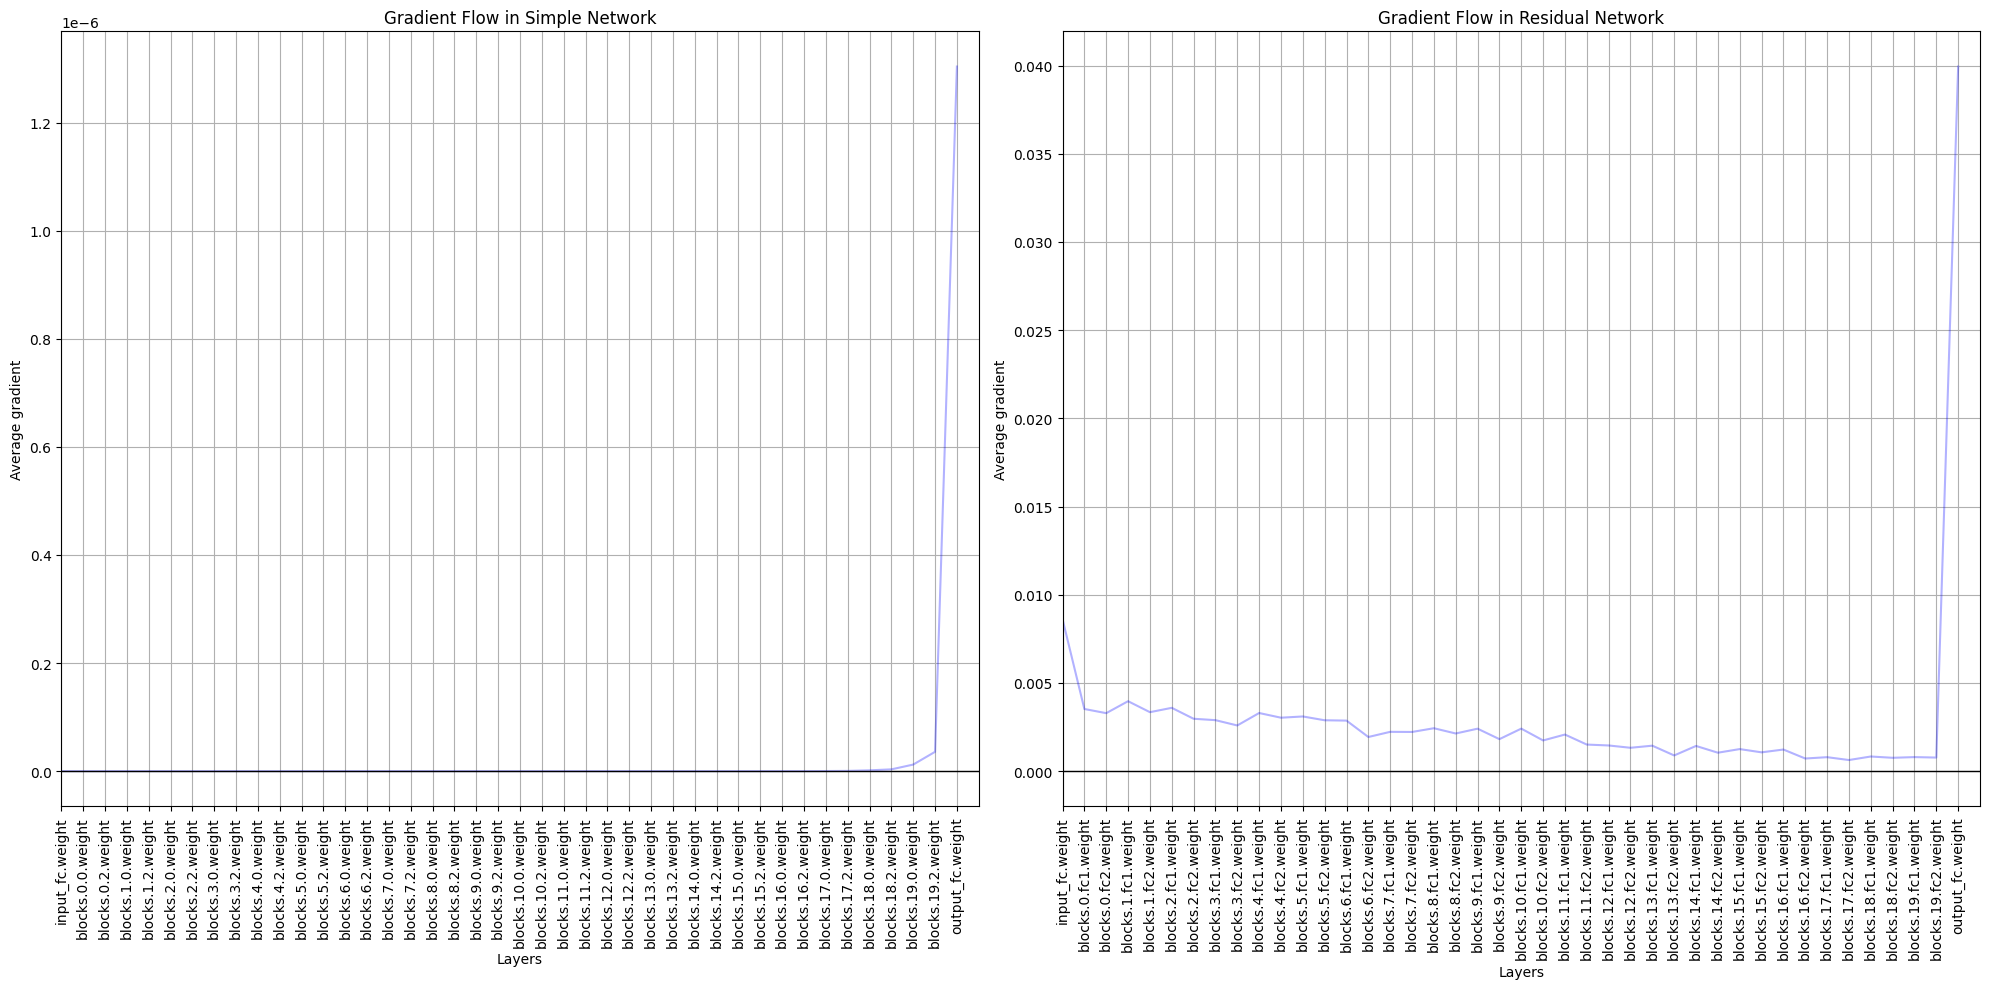

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate a more complex dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=10, n_classes=2, random_state=42)
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

# Split the data into train and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, in_features)
        self.fc2 = nn.Linear(in_features, in_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.relu(self.fc1(x))
        out = self.fc2(out)
        out += identity
        out = self.relu(out)
        return out

class DeepNet(nn.Module):
    def __init__(self, in_features, num_blocks, use_residual=False):
        super(DeepNet, self).__init__()
        self.use_residual = use_residual

        self.input_fc = nn.Linear(in_features, 64)
        self.blocks = nn.ModuleList([ResidualBlock(64) if use_residual else nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        ) for _ in range(num_blocks)])
        self.output_fc = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.input_fc(x))
        for block in self.blocks:
            if self.use_residual:
                x = block(x)
            else:
                x = block(x)
        x = torch.sigmoid(self.output_fc(x))
        return x

def train_model(model, X_train, y_train, epochs=100):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    return losses

# Train models with different depths
depths = [10, 20]
simple_losses = []
residual_losses = []

for depth in depths:
    print(f"\nTraining models with depth {depth}")

    simple_model = DeepNet(20, depth, use_residual=False)
    residual_model = DeepNet(20, depth, use_residual=True)

    print("Training Simple Network:")
    simple_loss = train_model(simple_model, X_train, y_train)
    simple_losses.append(simple_loss)

    print("\nTraining Residual Network:")
    residual_loss = train_model(residual_model, X_train, y_train)
    residual_losses.append(residual_loss)

    # Evaluate models
    simple_accuracy = (simple_model(X_test).round() == y_test.unsqueeze(1)).float().mean().item()
    residual_accuracy = (residual_model(X_test).round() == y_test.unsqueeze(1)).float().mean().item()

    print(f"\nDepth {depth} Results:")
    print(f"Simple Network Accuracy: {simple_accuracy:.4f}")
    print(f"Residual Network Accuracy: {residual_accuracy:.4f}")

# Visualize the training loss for different depths
plt.figure(figsize=(15, 5))
for i, depth in enumerate(depths):
    plt.subplot(1, 3, i+1)
    plt.plot(simple_losses[i], label='Simple Network')
    plt.plot(residual_losses[i], label='Residual Network')
    plt.title(f'Training Loss (Depth {depth})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.yscale('log')

plt.tight_layout()
plt.show()

# Visualize final layer activations
def plot_activations(model, X, y, title):
    model.eval()
    with torch.no_grad():
        activations = model.blocks[-1](model.blocks[-2](model.input_fc(X)))

    plt.figure(figsize=(10, 8))
    plt.scatter(activations[:, 0].numpy(), activations[:, 1].numpy(), c=y.numpy(), cmap='coolwarm', alpha=0.6)
    plt.title(title)
    plt.xlabel('Activation 1')
    plt.ylabel('Activation 2')
    plt.colorbar(label='Class')
    plt.show()

# Plot activations for the deepest models
deepest_simple_model = DeepNet(20, depths[-1], use_residual=False)
deepest_residual_model = DeepNet(20, depths[-1], use_residual=True)

train_model(deepest_simple_model, X_train, y_train)
train_model(deepest_residual_model, X_train, y_train)

plot_activations(deepest_simple_model, X_test, y_test, f'Simple Network Activations (Depth {depths[-1]})')
plot_activations(deepest_residual_model, X_test, y_test, f'Residual Network Activations (Depth {depths[-1]})')

# Gradient flow visualization
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().item())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("Average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plot_grad_flow(deepest_simple_model.named_parameters())
plt.title("Gradient Flow in Simple Network")

plt.subplot(1, 2, 2)
plot_grad_flow(deepest_residual_model.named_parameters())
plt.title("Gradient Flow in Residual Network")

plt.tight_layout()
plt.show()

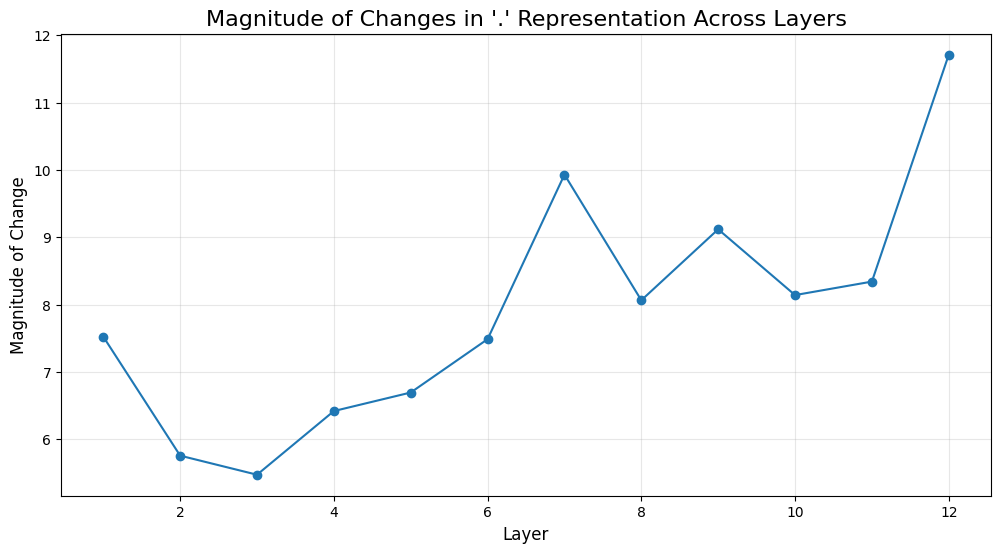

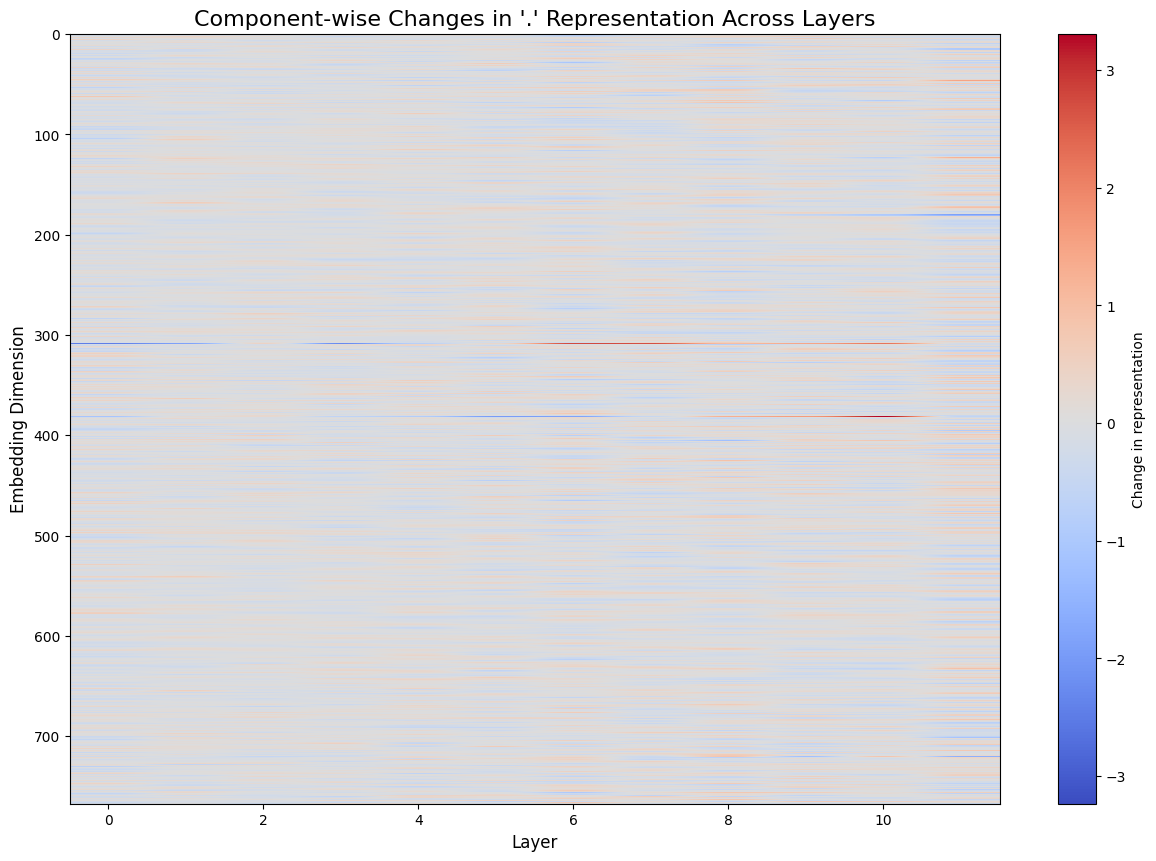

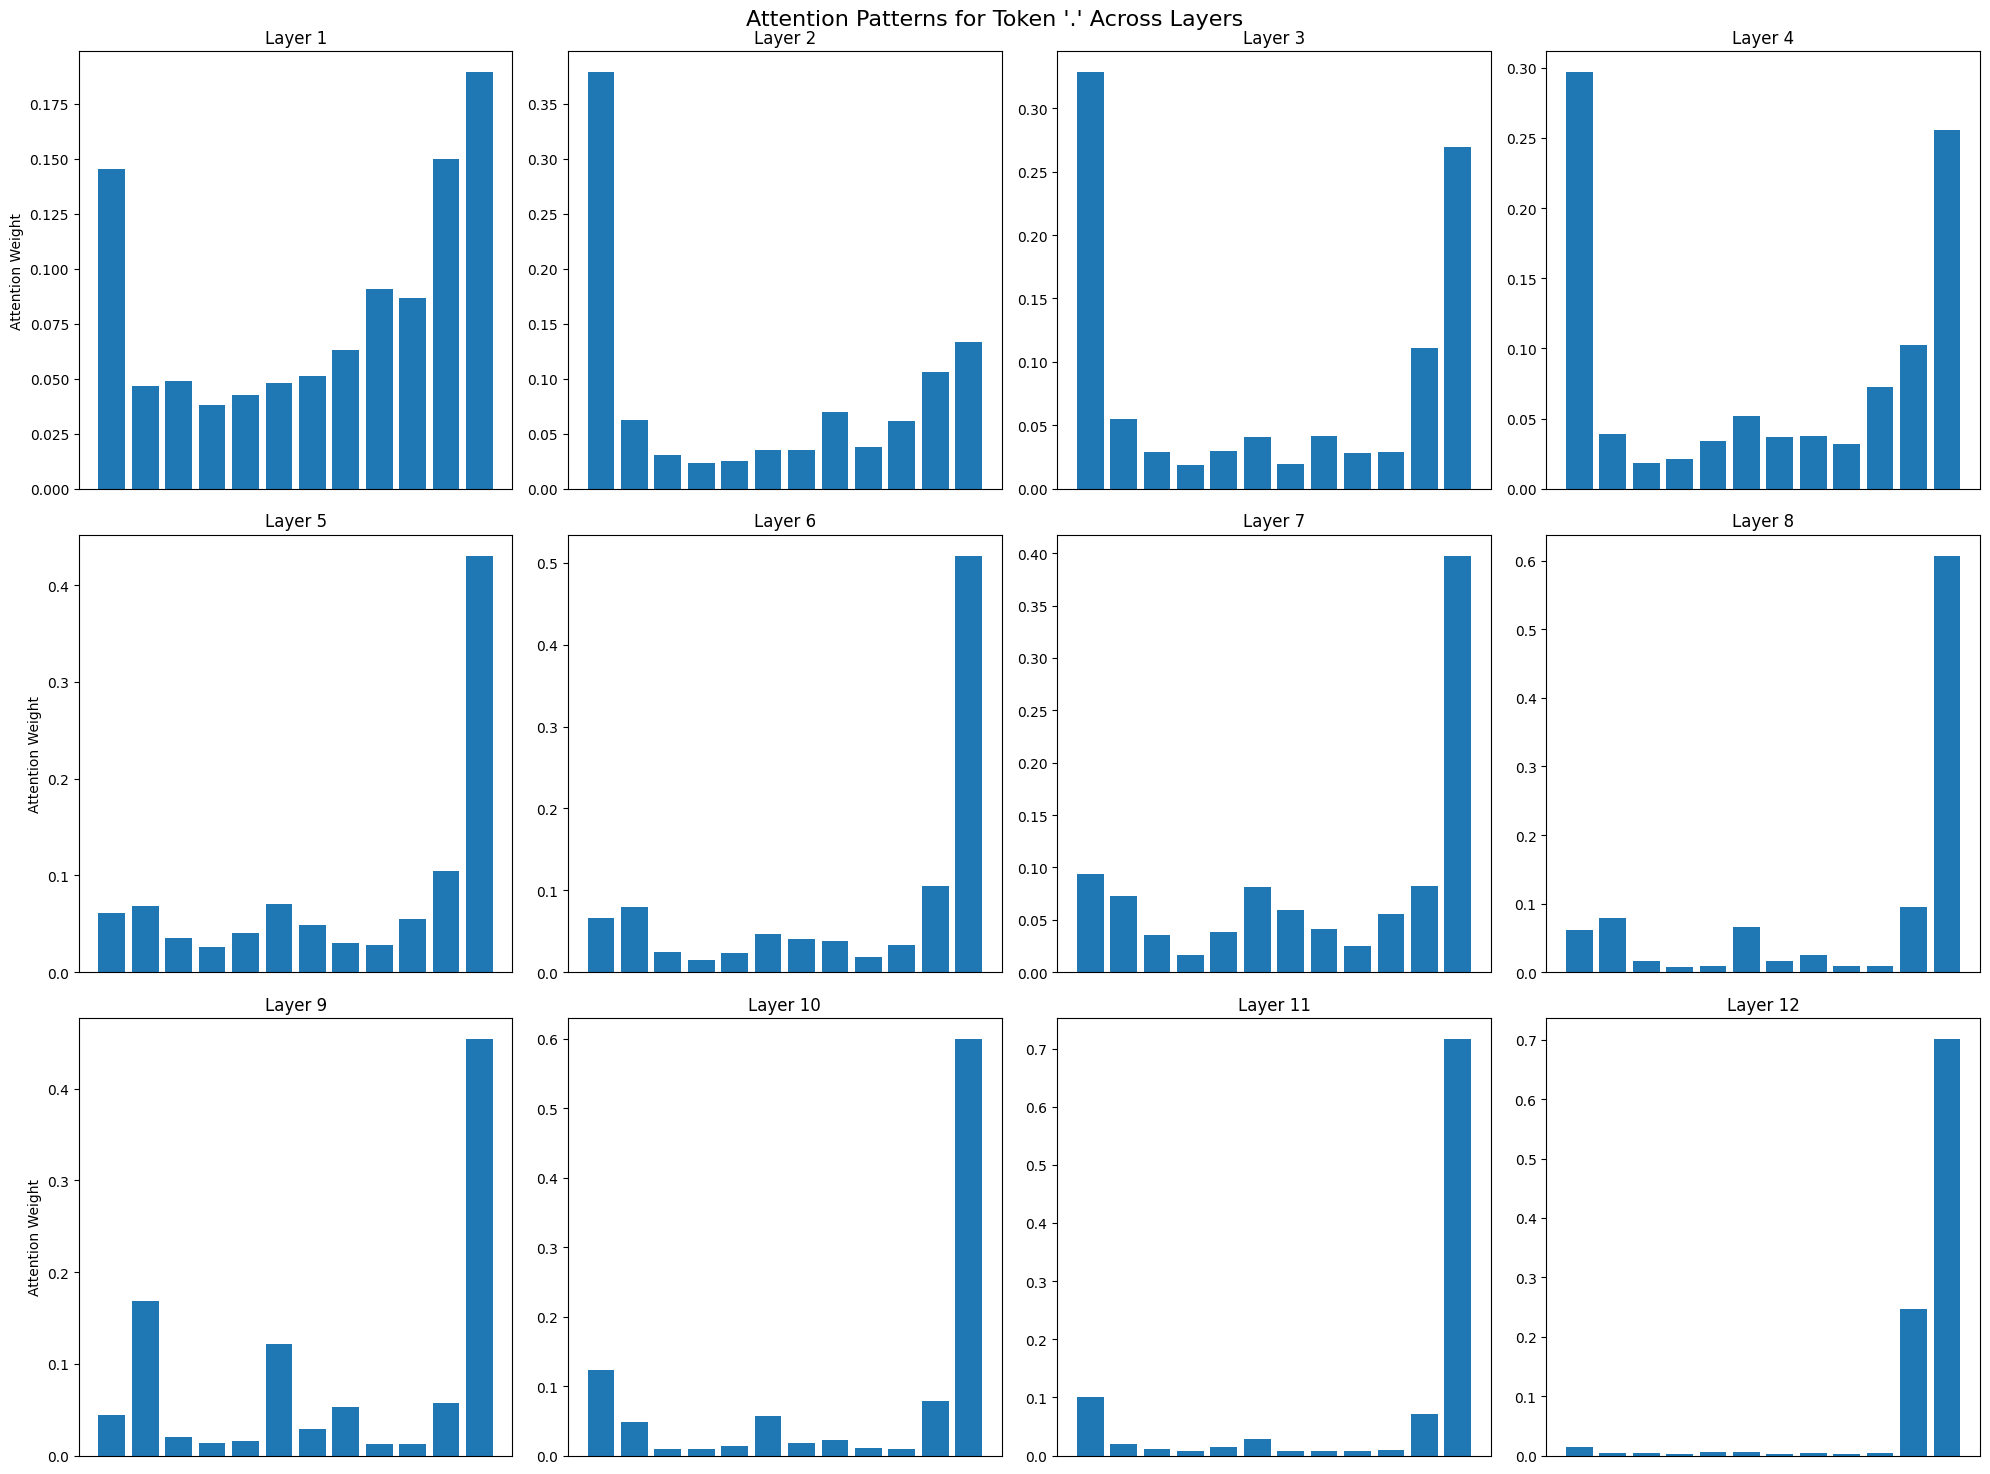

In [14]:
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import numpy as np
from typing import List

# Load pre-trained model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_hidden_states=True)

# Set the model to evaluation mode
model.eval()

def get_token_representations(text: str, target_token: str) -> List[torch.Tensor]:
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt")

    # Get the index of the target token
    target_token_id = tokenizer.encode(target_token, add_special_tokens=False)[0]
    target_index = (inputs.input_ids == target_token_id).nonzero(as_tuple=True)[1][0]

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract hidden states for all layers
    hidden_states = outputs.hidden_states

    # Extract representations for the target token from each layer
    token_representations = [state[0, target_index, :] for state in hidden_states]

    return token_representations

def visualize_token_evolution(representations: List[torch.Tensor], token: str):
    # Convert representations to numpy arrays
    rep_arrays = [rep.numpy() for rep in representations]

    # Calculate the differences between consecutive layers
    diffs = [rep_arrays[i+1] - rep_arrays[i] for i in range(len(rep_arrays)-1)]

    # Calculate magnitudes of changes
    magnitudes = [np.linalg.norm(diff) for diff in diffs]

    # Visualize magnitudes of changes
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(magnitudes) + 1), magnitudes, marker='o')
    plt.title(f"Magnitude of Changes in '{token}' Representation Across Layers", fontsize=16)
    plt.xlabel("Layer", fontsize=12)
    plt.ylabel("Magnitude of Change", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

    # Visualize component-wise changes
    plt.figure(figsize=(15, 10))
    plt.imshow(np.array(diffs).T, aspect='auto', cmap='coolwarm')
    plt.colorbar(label='Change in representation')
    plt.title(f"Component-wise Changes in '{token}' Representation Across Layers", fontsize=16)
    plt.xlabel("Layer", fontsize=12)
    plt.ylabel("Embedding Dimension", fontsize=12)
    plt.show()

# Example usage
text = "The quick brown fox jumps over the lazy dog."
target_token = "."

token_representations = get_token_representations(text, target_token)
visualize_token_evolution(token_representations, target_token)

# Analyze attention patterns
def visualize_attention_patterns(text: str, target_token: str):
    inputs = tokenizer(text, return_tensors="pt")
    target_token_id = tokenizer.encode(target_token, add_special_tokens=False)[0]
    target_index = (inputs.input_ids == target_token_id).nonzero(as_tuple=True)[1][0]

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    attentions = outputs.attentions

    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle(f"Attention Patterns for Token '{target_token}' Across Layers", fontsize=16)

    for layer, layer_attention in enumerate(attentions):
        ax = axes[layer // 4, layer % 4]
        attention_weights = layer_attention[0, :, target_index, :].mean(dim=0)
        ax.bar(range(len(attention_weights)), attention_weights)
        ax.set_title(f"Layer {layer + 1}")
        ax.set_xticks([])
        if layer % 4 == 0:
            ax.set_ylabel("Attention Weight")

    plt.tight_layout()
    plt.show()

visualize_attention_patterns(text, target_token)